<p style = 'font-size:40px'> <strong>Analyzing Airbnb Data</strong> </p>

* <p style = 'font-size:20px'> This project aims to explore informations about a data set regarding Boston's Airbnb registered  dwellings.</p>

* <p style = 'font-size:20px'> I've challenged myself to perform the following tasks:</p>

<p style = 'font-size:20px;margin-left:50px'> 1 - Get the dwelling type composition per neighborhood.</p>
<p style = 'font-size:20px;margin-left:50px'> 2 -  Compare the average prices among residences with different reputations among their customers. </p>
<p style = 'font-size:20px;margin-left:50px'> 3 - Find out whether Airbnb superhosts take advantadge of their status in order to charge higher prices to their customers. </p>
<p style = 'font-size:20px;margin-left:50px'> 4 - Discover if it is more expensive to stay in Boston's richer neighborhoods.</p>

<p style = 'font-size:30px'> <strong>Data set presentation</strong> </p>

* <p style = 'font-size:20px'> Here, I'll let you take a glimpse on the data set we are going to explore in this project. Since it contains multiple columns I am going to select just the ones that we need.</p>

In [163]:
import pandas as pd
import numpy as np

usecols = ['id', 'host_is_superhost', 'neighbourhood', 'property_type', 'price', 'review_scores_value']
airbnb = pd.read_csv('listings.csv', usecols = usecols)
airbnb.head()

,id,host_is_superhost,neighbourhood,property_type,price,review_scores_value
0,12147973,f,Roslindale,House,$250.00,NaN
1,3075044,f,Roslindale,Apartment,$65.00,9.0
2,6976,t,Roslindale,Apartment,$65.00,10.0
3,1436513,f,NaN,House,$75.00,10.0
4,7651065,t,Roslindale,House,$79.00,10.0


<p style = 'font-size:30px'> <strong>Cleaning the data</strong> </p>

* <p style = 'font-size:20px'> Since we are making a neighborhood-based analysis, it is necessary that all the dwellings have their neighborhood name in the <em> neighbourhood</em> column.</p>
* <p style = 'font-size:20px'> Unfortunately, this is not the case for some of the lodgings. Therefore we need to remove them from the DataFrame.</p>

In [165]:
# Deleting the dwellings with no neighborhood specified.
airbnb = airbnb[~airbnb['neighbourhood'].isnull()]

# On top of that, the columns related to prices are not being recognized as numbers, 
# since all their rows have a '$' sign in front of the numbers and  ',' as thousands separator.
replacement = {'\$':'', ',':''}

airbnb['price'] = (airbnb['price']
                  .replace(replacement, regex = True)
                  .astype('float')) 

* <p style = 'font-size:20px'> Furthermore, it is important to mention that some lodgings do not have their neighborhood correctly written in the "neighbourhood" column. Instead they have touristic places registered.</p>

* <p style = 'font-size:20px'> We'll substitute the touristic location name for the residence's actual neighborhood.</p>

* <p style = 'font-size:20px'>Also, because we are performing a Boston exclusive analysis, we need to disregard some of the dwellings which belong to cities from the surrouding area (like Cambridge, Sommerville, Chesnut Hill and Brookline).</p>

In [166]:
# A dictionary conataining the replacements for the touristic locations names.
substitute = {'Downtown Crossing':'Downtown',
            'Government Center': 'Downtown',
            'Leather District':'Downtown',
             'Chinatown': 'Downtown',
            'Theater District':'Downtown',
            'Financial District': 'Downtown'}

airbnb = airbnb.replace(substitute) 

# A list with the names of the cities/places that do not belong to Boston's area.
to_drop = ['Somerville', 'Chesnut Hill', 'Harvard Square', 'Brookline', 'Cambridge']

for index, neighborhood in zip(airbnb.index, airbnb['neighbourhood']):
    if neighborhood in to_drop:
        airbnb.drop(index = index, inplace = True)
        
# Now we have finally cleaned our data! Let's carry out our tasks!
sorted(airbnb['neighbourhood'].unique())

['Allston-Brighton',
 'Back Bay',
 'Beacon Hill',
 'Charlestown',
 'Chestnut Hill',
 'Dorchester',
 'Downtown',
 'East Boston',
 'Fenway/Kenmore',
 'Hyde Park',
 'Jamaica Plain',
 'Mattapan',
 'Mission Hill',
 'North End',
 'Roslindale',
 'Roxbury',
 'South Boston',
 'South End',
 'West End',
 'West Roxbury']

<p style = 'font-size:30px'> <strong>Task 1</strong> </p>

* <p style = 'font-size:20px'> The output of this operation will be a sunburst chart. It will contain some of Boston's neighborhoods along with their property types composition.</p>

* <p style = 'font-size:20px'> We need to consider that Boston has many neighborhoods, so using the informations from all of them can make our graph's visual poluted.</p>

In [167]:
# Considering this, we'll establish a rule: we'll plot the property type compostion for only the 6 locations
# with most dwellings registered on Airbnb.

# Which are those neghborhoods?
top_6 = airbnb.groupby(['neighbourhood'])['id'].count().sort_values(ascending = False).head(6)
top_6

neighbourhood
Allston-Brighton    364
Jamaica Plain       314
South End           298
Back Bay            291
Fenway/Kenmore      249
South Boston        216
Name: id, dtype: int64

In [168]:
# Let's make a list containing all the 'top_6' Series neighborhoods.
desirable_neighborhoods = list(top_6.index)
desirable_neighborhoods

['Allston-Brighton',
 'Jamaica Plain',
 'South End',
 'Back Bay',
 'Fenway/Kenmore',
 'South Boston']

In [169]:
# Now that we know the locations we are going to use, it is time to plot our sunburst chart!
import plotly.express as px

# Below, we'll perform a group by. It will list all neighborhoods and their property types available. Also, it will
# count the number of dwellings each residence kind has.
property_types_count = airbnb.groupby(['neighbourhood','property_type'], as_index = False)['id'].count()
property_types_count = (property_types_count.
                        sort_values(by = 'id', ascending = False)
                       ) 

property_types_count.head()

,neighbourhood,property_type,id
9,Back Bay,Apartment,247
0,Allston-Brighton,Apartment,245
93,South End,Apartment,241
48,Fenway/Kenmore,Apartment,239
55,Jamaica Plain,Apartment,176


In [170]:
# The 'property_types_count' mentions the property types from all Boston's neighborhoods, but we won't need all
# of them (as we've defined earlier).

# We are going to filter the DF so that it only contains residences registered in the 'desirable_neighborhoods' list.
property_types_count = property_types_count[property_types_count['neighbourhood'].isin(desirable_neighborhoods)]

print(property_types_count['neighbourhood'].unique())
property_types_count.head()

['Back Bay' 'Allston-Brighton' 'South End' 'Fenway/Kenmore'
 'Jamaica Plain' 'South Boston']


,neighbourhood,property_type,id
9,Back Bay,Apartment,247
0,Allston-Brighton,Apartment,245
93,South End,Apartment,241
48,Fenway/Kenmore,Apartment,239
55,Jamaica Plain,Apartment,176


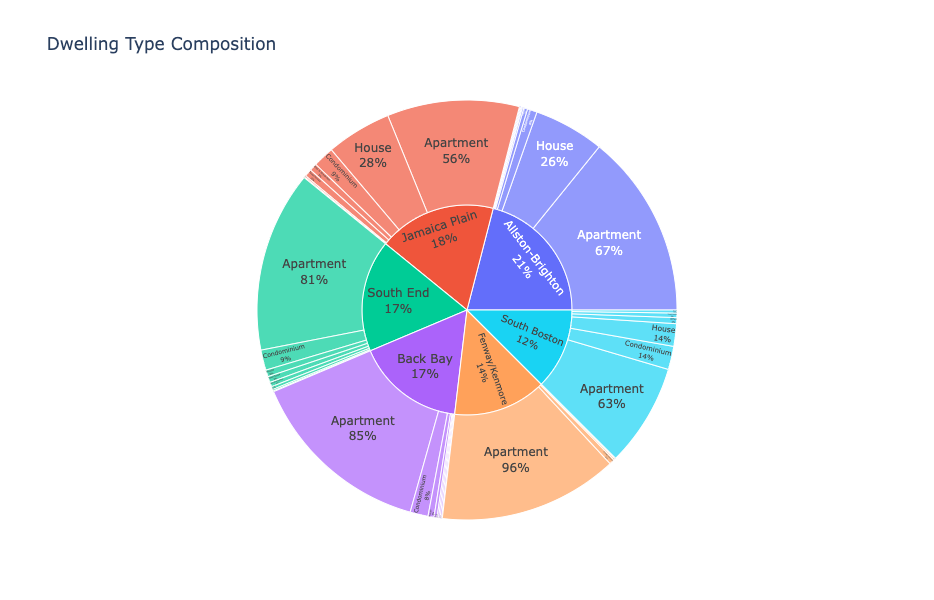

In [171]:
# Now that we know the locations we are going to use, it is time to plot our sunburst chart!

# Unfortunately plotly has a bug for the sunburst plot in which it does not recognize the 'id' column
# for the chart creation. Thus we'll have to make a second column with the same data.
# We are going to call the new column 'Number of Dwellings'
property_types_count['Number of Dwellings'] = property_types_count['id']

# Finally plotting the sunburst chart!
figure = px.sunburst(property_types_count, values = 'Number of Dwellings', path = ['neighbourhood','property_type'], 
                     width = 600, height = 600, title = 'Dwelling Type Composition')
figure.update_traces(textinfo="label+percent parent")
figure.show()

<p style = 'font-size:30px'> <strong>Task 2</strong> </p>

In [172]:
# In this task, I am going to create four categories for the ratings from the 'review_scores_value' column.
# Each of the ratings categories will contain the same number of dwellings.
categories = pd.cut(airbnb['review_scores_value'].dropna(), 4)
categories

1        (8.0, 10.0]
2        (8.0, 10.0]
4        (8.0, 10.0]
5        (8.0, 10.0]
7        (8.0, 10.0]
            ...     
3529    (1.992, 4.0]
3532     (8.0, 10.0]
3533      (6.0, 8.0]
3534     (8.0, 10.0]
3574      (6.0, 8.0]
Name: review_scores_value, Length: 2350, dtype: category
Categories (4, interval[float64]): [(1.992, 4.0] < (4.0, 6.0] < (6.0, 8.0] < (8.0, 10.0]]

In [173]:
# Each one of the categories will have a label indicating the dwelling's quality.
categories = pd.cut(airbnb['review_scores_value'].dropna(), 4,
                   labels = ['Poor', 'Avergage', 'Good', 'Excellent'])
categories

1       Excellent
2       Excellent
4       Excellent
5       Excellent
7       Excellent
          ...    
3529         Poor
3532    Excellent
3533         Good
3534    Excellent
3574         Good
Name: review_scores_value, Length: 2350, dtype: category
Categories (4, object): ['Poor' < 'Avergage' < 'Good' < 'Excellent']

In [174]:
# Transforming the Categorical object into a column:
airbnb['Lodging Quality'] = categories
airbnb.head(5)

,id,host_is_superhost,neighbourhood,property_type,price,review_scores_value,Lodging Quality
0,12147973,f,Roslindale,House,250.0,NaN,NaN
1,3075044,f,Roslindale,Apartment,65.0,9.0,Excellent
2,6976,t,Roslindale,Apartment,65.0,10.0,Excellent
4,7651065,t,Roslindale,House,79.0,10.0,Excellent
5,12386020,t,Roslindale,Condominium,75.0,10.0,Excellent


In [175]:
# As you've probably seen, the DF contains rows from residences with no 'review_scores_value' rating and thus no
# Lodging Quality specified.

# As these dwellings have no utility to our analysis, wel'll drop them from the DF.
no_nan = airbnb[~airbnb['review_scores_value'].isnull()]
no_nan.head()

,id,host_is_superhost,neighbourhood,property_type,price,review_scores_value,Lodging Quality
1,3075044,f,Roslindale,Apartment,65.0,9.0,Excellent
2,6976,t,Roslindale,Apartment,65.0,10.0,Excellent
4,7651065,t,Roslindale,House,79.0,10.0,Excellent
5,12386020,t,Roslindale,Condominium,75.0,10.0,Excellent
7,2843445,t,Roslindale,House,75.0,10.0,Excellent


Text(0.5, 1.0, 'Average Price per Dwelling Quality')

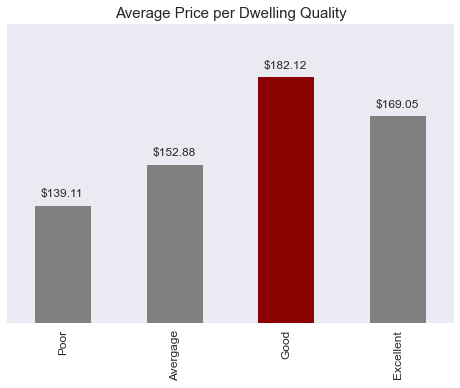

In [176]:
# With everything done, it is time to plot the chart.
from matplotlib.pyplot import style
# Setting the 'seaborn' chart style.
style.use('seaborn')

# Grouping the dwellings accordingly to their 'Lodging Quality' reputation and calculating the average price for each
# category.
groups = no_nan.groupby('Lodging Quality')['price'].mean()

# Defining the chart's parameters
chart = groups.plot(kind = 'bar', ylim = (100,200) , xlabel = '', yticks = [], 
                    fontsize = 12, grid = False, color = ['grey','grey', 'darkred', 'grey'])

# Configuring matplotlib to display the average price for each of the graph's bars.
for i, price in enumerate(groups):
    plt.text(-0.2 + i, price + 3, f'${price:.2f}', fontdict = {'size':12})

# Defining the graph's title
plt.title('Average Price per Dwelling Quality', fontdict = {'size':15})

<p style = 'font-size:30px'> <strong>Task 3</strong> </p>

* <p style = 'font-size:20px'> In Airbnb you can get a superhost status if your profile matches a set of conditions.</p>

* <p style = 'font-size:20px'> This title can provide you a sense of credibility among Airbnb users. </p>

* <p style = 'font-size:20px'> But in regard to the Boston's Airbnb superhosts, do they take advantadge of their status in order impose a higher price on their lodgings?</p>

In [177]:
# We can check it through an hypothesis test!

# Null hypothesis: Airbnb owned dwellings got the SAME price as the ones possessed by common hosts.
# Alternative hypothesis: Airbnb superhosts owned dwellings DO NOT HAVE SAME price as the ones 
                                                                    # possessed by common hosts.
    
# To carry out our hypothesis test, we need equally-sized samples.
# Let's create a group of 100 lodgings owned by superhosts and another one of the same size containing the ones
# possessed by common hosts.
superhost = airbnb[airbnb['host_is_superhost'] == 't']['price'].sample(100)
non_superhost = airbnb[airbnb['host_is_superhost'] == 'f']['price'].sample(100)

In [178]:
# The significance level is going to be 5%
from scipy.stats import ttest_rel

# Performing the hypothesis test with scipy.stats ttest_rel method.
# The p-value generated is higher than the significance level.
ttest_rel(superhost, non_superhost)

Ttest_relResult(statistic=0.8682053904236512, pvalue=0.38738167078607766)

0.38738167078607766


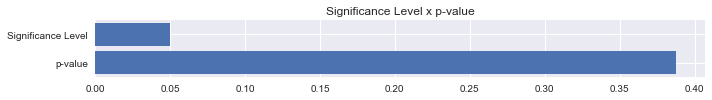

In [179]:
import matplotlib.pyplot as plt
# We are going to plot the Significance Level and the p-value obtained.
pvalue = ttest_rel(superhost, non_superhost)[1]
print(pvalue)

fig = plt.figure(figsize = (10,1.5))
plt.barh(y = ['p-value', 'Significance Level'], width = [pvalue, 0.05], linewidth = 0.2)

plt.title('Significance Level x p-value')

plt.margins(y = 0.05)
plt.tight_layout()

<p style = 'font-size:30px'> <strong>Task 4</strong> </p>

* <p style = 'font-size:20px'> I've encountered an Excel file made by American Community Survey containing many demographic statistics from Boston's neighborhoods. I'll use a sheet displaying the Per Capita Income of each one of the locations.</p>

* <p style = 'font-size:20px'> Our mission is going to answer the following question: How much is the correlation between the neighborhoods' Per Capita Income and their Airbnb dwellings' average price?  Is it more expensive to stay in a richer region of Boston?</p>

* <p style = 'font-size:20px'> If you'd like to access the full document you can click <a href = 'https://data.boston.gov/dataset/neighborhood-demographics'> here</a>. The file is the third one from the list.</p>

In [242]:
# Importing the Excel sheet.
per_capita = pd.read_excel('2015-2019_neighborhood_tables_2021.12.21.xlsm', sheet_name='Per Capita Income', 
                          header = 2, usecols = [0,1,3], 
                        names = ['Neighborhood', 'Total Population', 'Per Capita Income'],
                          skiprows=[1,2,3,28, 29, 30, 31, 32, 33, 34], index_col=0)

# Making a little adjustment on the name of Fenway neighborhood.
per_capita.rename(index = {'Fenway' : 'Fenway/Kenmore'}, inplace = True)
per_capita.head()

,Total Population,Per Capita Income
Neighborhood,,
Allston,19261,34148.709828
Back Bay,17783,110676.820559
Beacon Hill,9648,100005.286070
Brighton,55297,41261.375843
Charlestown,19890,75338.893917


* <p style = 'font-size:20px'> We can see that differently from what the 'airbnb' DF shows, Brighton and Allston are actually two separated neighborhoods.</p>

* <p style = 'font-size:20px'> But in order to work with the Airbnb data we need to convert the informations from both neighborhoods into a single row with the name 'Allston-Brighton'.</p>

In [243]:
# Getting the neighborhoods' population sum.
allst_bright_pop = per_capita.loc['Allston', 'Total Population'] + per_capita.loc['Brighton', 'Total Population']

a =(per_capita.loc['Allston', 'Total Population'] / allst_bright_pop) * per_capita.loc['Allston', 'Per Capita Income']

b =(per_capita.loc['Brighton', 'Total Population']/ allst_bright_pop) * per_capita.loc['Brighton', 'Per Capita Income']

# Evaluating the average Per Capita Income from the 'Allston-Brighton' area.
alls_bright_capita = a+b
alls_bright_capita

39423.91963303737

In [244]:
# With the right data in our hands, we are able to create the new row.
per_capita.loc['Allston-Brighton'] = allst_bright_pop, alls_bright_capita
per_capita.loc['Allston-Brighton']

# Dropping the 'Allston' and 'Brighton' rows.
per_capita.drop(index = ['Allston', 'Brighton'], inplace = True)

In [245]:
# We are going to get the average price for each of the neighborhoods contained in the 'airbnb' DF.
average_price = airbnb.groupby('neighbourhood')['price'].mean()
average_price.head()

neighbourhood
Allston-Brighton    114.162088
Back Bay            245.457045
Beacon Hill         212.080460
Charlestown         210.050633
Chestnut Hill        70.750000
Name: price, dtype: float64

In [246]:
# Now, we'll join the 'average price' Series with the 'per_capita' DF.
price_per_capita = pd.merge(average_price, per_capita, 
                            left_index= True, right_on = 'Neighborhood').drop(columns = 'Total Population')
price_per_capita.head()

,price,Per Capita Income
Neighborhood,,
Allston-Brighton,114.162088,39423.919633
Back Bay,245.457045,110676.820559
Beacon Hill,212.080460,100005.286070
Charlestown,210.050633,75338.893917
Dorchester,97.451282,29767.207999


In [247]:
# Aiming higher accuracy in our analysis, we are going to normalize the columns' values using 
# the Min-Max Feature Scaling.
def min_max(column):
    return (column - column.min()) / (column.max() - column.min())

price_per_capita = price_per_capita.apply(min_max)
price_per_capita.head()

,price,Per Capita Income
Neighborhood,,
Allston-Brighton,0.243069,0.205646
Back Bay,1.000000,1.000000
Beacon Hill,0.807580,0.881030
Charlestown,0.795878,0.606039
Dorchester,0.146730,0.097989


In [248]:
# With everything set we are able to measure the correlation coefficient between the 
# 'price' and 'Per Capita Income' columns.
from scipy.stats import pearsonr

# And here is the value. 
pearsonr(price_per_capita['price'], price_per_capita['Per Capita Income'])[0]

0.7419441871562023

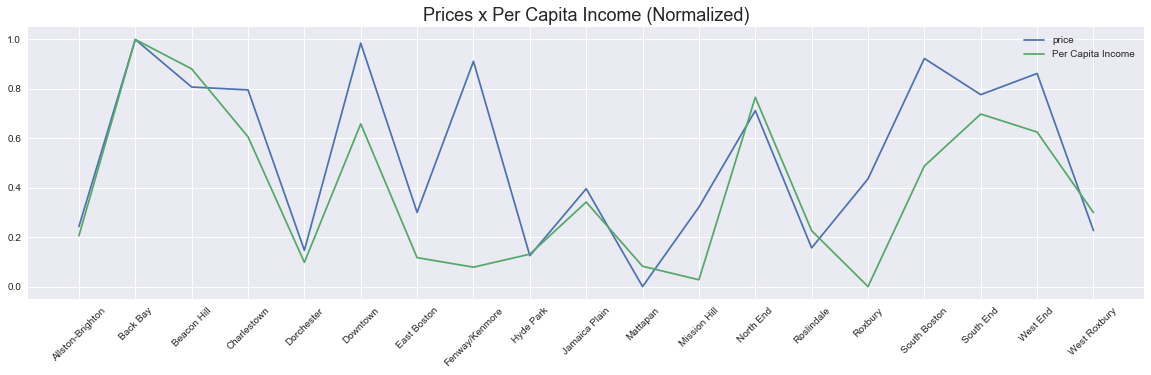

In [278]:
# It is convenient to plot a line chart displaying the different values of 'price' and 'Per Capita Income' along
# the DataFrame's rows.
price_per_capita.plot(figsize = (20,5),xlabel = '',xticks = range(len(price_per_capita)))

plt.gca().set_title('Prices x Per Capita Income (Normalized)', fontsize = 18 )
x = plt.gca().xaxis
for label in x.get_ticklabels():
    label.set_rotation(45)